In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import firedrake
import icepack, icepack.models, icepack.plot
from icepack.constants import ice_density as ρ_I, water_density as ρ_W, gravity as g

In [2]:
Lx, Ly = 1e3, 1e3
nx, ny = 20, 20
mesh2d = firedrake.RectangleMesh(nx, ny, Lx, Ly)
mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)

In [3]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2, vfamily='DG', vdegree=0)
V = firedrake.VectorFunctionSpace(mesh, dim=2, family='CG', degree=2, vfamily='GL', vdegree=6)
Q3D = firedrake.FunctionSpace(mesh, family='DG', degree=2, vfamily='GL', vdegree=1+V.ufl_element().degree()[1])

In [4]:
x, y, ζ = firedrake.SpatialCoordinate(mesh)

In [5]:
b = firedrake.interpolate(firedrake.Constant(0.0), Q)
s = firedrake.interpolate(firedrake.Constant(1000), Q)
h = firedrake.interpolate(s - b, Q)

ux = firedrake.Constant(40)
uy = firedrake.Constant(0)
uz = firedrake.Constant(-40)
u = firedrake.interpolate(firedrake.as_vector((ux, uy)), V)
w = firedrake.interpolate(uz/h,Q3D)

age = firedrake.interpolate(firedrake.Constant(0.0),Q3D)

In [6]:
x0=0
y0=0
z0=0
age0=0

In [7]:
def velocity_3D(**kwargs):
    u = kwargs['velocity']
    h = kwargs['thickness']
    uz = kwargs['uz']
    
    Q = h.function_space()
    V = u.function_space()
    mesh = Q.mesh()
    xdegree_u, zdegree_u = u.ufl_element().degree()
    W = firedrake.FunctionSpace(mesh, family='CG', degree=2, vfamily='GL', vdegree=1+V.ufl_element().degree()[1])
    w = firedrake.interpolate(uz/h,W)
    V3D = firedrake.VectorFunctionSpace(mesh, dim=3, family='CG', degree=xdegree_u, vfamily='GL',vdegree=zdegree_u+1)
    u3D = firedrake.Function(V3D).interpolate(firedrake.as_vector((u[0],u[1],w)))
    
    return u3D

In [8]:
u3D = velocity_3D(velocity=u, thickness=h, uz=uz)

In [9]:
age_model = icepack.models.AgeTransport(velocity_3D=velocity_3D)
age_solver = icepack.solvers.AgeSolver(age_model)

In [10]:
import tqdm
import numpy as np

num_years = 20.0
timesteps_per_year = 5.0

δt = 1.0 / timesteps_per_year
num_timesteps = int(num_years * timesteps_per_year)

num_age = np.zeros((num_timesteps,1))*np.nan
ana_age = np.zeros((num_timesteps,1))*np.nan
ts = np.zeros((num_timesteps,1))*np.nan

for step in tqdm.trange(num_timesteps):
    age = age_solver.solve(δt,velocity=u,thickness=h,age=age,uz=uz)
    t = step*δt
    ts[step] = t
    num_age[step] = age.at(x0+ux*t,y0+uy*t,z0+(1000+uz*t)/1000,tolerance=1e-10)
    ana_age[step] = age0+t

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


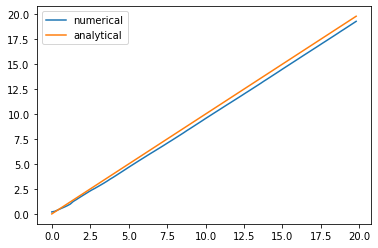

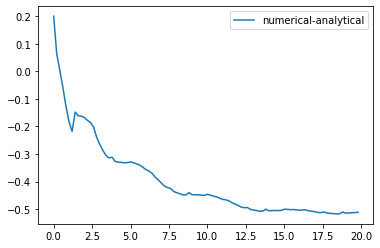

In [11]:
plt.figure()
plt.plot(ts,num_age,label="numerical")
plt.plot(ts,ana_age,label="analytical")
plt.legend()

plt.figure()
plt.plot(ts,num_age-ana_age,label="numerical-analytical")
plt.legend()

In [16]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

nz=20

xs = np.array([(Lx * k / nx, 0, .5) for k in range(nx + 1)])
ss = np.array(s.at(xs, tolerance=1e-10))
hs = np.array(h.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))

xz = np.array([(Lx * k / nx, 0, i)  for k in range(nx + 1) for i in np.arange(0,1.0,1.0/nz)])
ageM= np.array(age.at(xz, tolerance=1e-10))
ageM=np.reshape(ageM,(21,nz));
xz=np.reshape(xz,(21,nz,3));
hz=np.reshape(np.repeat(hs,nz),(21,nz));
hz=np.multiply(xz[:,:,2],hz);

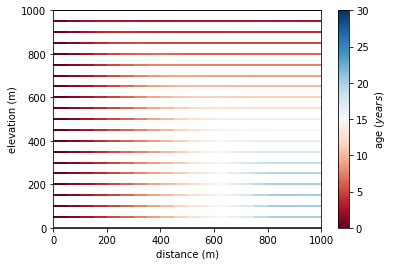

In [17]:
fig, axs = plt.subplots()
for i in range(0,nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(ss-hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(0,30)
    lc = LineCollection(segments, cmap='RdBu', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(ageM[:,nz-1-i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'age $(years)$')
axs.set_ylabel('elevation (m)')
axs.set_xlabel('distance (m)')
plt.show()